# Configuration

In [132]:
import numpy as np
import jax.numpy as jnp
import pandas as pd

import polaris as po
from polaris.hub.client import PolarisHubClient

import tanimoto_gp
from utils import smiles_to_fp, optimize_params

import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial
import warnings
warnings.filterwarnings("ignore")

In [135]:
# Set up Seaborn plotting style
sns.set_style("darkgrid",
              {"axes.facecolor": ".95",
               "axes.edgecolor": "#000000",
               "grid.color": "#EBEBE7",
               "font.family": "serif",
               "axes.labelcolor": "#000000",
               "xtick.color": "#000000",
               "ytick.color": "#000000",
               "grid.alpha": 0.4 })
sns.set_palette('muted')

In [20]:
client = PolarisHubClient()
client.login()

dataset = po.load_dataset("biogen/adme-fang-v1")

2025-01-15 09:24:11.801 | SUCCESS  | polaris.hub.client:login:268 - You are successfully logged in to the Polaris Hub.


⠧ Fetching dataset... 

2025-01-15 09:24:12.426 | INFO     | polaris._artifact:_validate_version:84 - The version of Polaris that was used to create the artifact (dev) is different from the currently installed version of Polaris (0.9.1).
2025-01-15 09:24:12.433 | INFO     | polaris.mixins._checksum:verify_checksum:65 - To verify the checksum, we need to recompute it. This can be slow for large datasets.


✅ SUCCESS: Fetched dataset.
 


# Data Processing

In [21]:
dataset.size()

(3521, 9)

In [33]:
dataset.get_data(
    row=dataset.rows[0],
    col=dataset.columns[1]
)

'Brc1cc2c(cc1Cn1cncn1)OCCCO2'

In [61]:
# Get all SMILES strings and logP values from dataset
X = [dataset.get_data(
    row=dataset.rows[i],
    col='MOL_smiles'
    ) for i in range(dataset.size()[0])]

y = [dataset.get_data(
    row=dataset.rows[i],
    col='LOG_SOLUBILITY'
    ) for i in range(dataset.size()[0])]

In [76]:
# Filter molecules with NaN logP values
filter = ~np.isnan(y)

X = [i for idx, i in enumerate(X) if filter[idx]]
y = [i for idx, i in enumerate(y) if filter[idx]]

In [77]:
len(X)

2173

# Bayesian Optimization

In [101]:
def upper_confidence_bound(X, gp, gp_params, beta=2.576):
    """
    Computes the upper confidence bound (UCB) at points X
    using a fitted Gaussian process surrogate model

    Args:
        X: Points at which UCB will be computed (m x d)
        gp: A GP model fitted to samples
        beta: Exploration-epxloitation trade-off parameter.
               Default is 2.576 (99% confidence interval)

    Returns:
        UCB scores at points X
    """

    # Get mean and standard deviation predictions
    mean, var = gp.predict_y(gp_params, X, full_covar=False)

    # Calculate upper confidence bound
    ucb = mean + beta * np.sqrt(var)

    return ucb

Start MLL: -553.8016967773438
End MLL (after optimization): -448.8641052246094
End GP parameters (after optimization): TanimotoGP_Params(raw_amplitude=Array(-0.0055478, dtype=float32), raw_noise=Array(-0.96249396, dtype=float32))


In [ ]:
X_new = np.argmax(ucb)

In [155]:
split = int(.2 * len(X))

X_observed, X_unlabeled = X[:split], X[split:]
y_observed, y_unlabeled = y[:split], y[split:]

gp = tanimoto_gp.TanimotoGP(smiles_to_fp, X_observed, y_observed)
gp_params = tanimoto_gp.TanimotoGP_Params(raw_amplitude=jnp.asarray(1.0), raw_noise=jnp.asarray(1e-2))
gp_params = optimize_params(gp, gp_params)

best = []

for i in range(30):

    best.append(np.max(y_observed))

    ucb = upper_confidence_bound(X_unlabeled, gp, gp_params)
    idx = np.argmax(ucb)

    X_new = X_unlabeled.pop(idx)
    y_new = y_unlabeled.pop(idx)

    print(idx, X_new, y_new)

    X_observed.append(X_new)
    y_observed.append(y_new)

    gp = tanimoto_gp.TanimotoGP(smiles_to_fp, X_observed, y_observed)

Start MLL: -553.8016967773438
End MLL (after optimization): -448.8641052246094
End GP parameters (after optimization): TanimotoGP_Params(raw_amplitude=Array(-0.0055478, dtype=float32), raw_noise=Array(-0.96249396, dtype=float32))
107 CN(C)[C@@H]1CN(C(=O)CCn2cnc3ccccc32)C[C@H]1O 2.179264464
1443 O=C(NCCCn1ccnc1)N1CCC12CCC2 1.614053106
259 COCC(=O)N1CCN2C(=O)NC[C@H]2C1 1.584331224
390 COc1ccc(CCC(=O)N2CCCNCC2)cc1 1.552668216
1404 O=C(Cc1cccc(I)c1)N1CC(CO)C1 1.624282096
167 CN(Cc1nnc(C2CC2)n1C)C(=O)C1C2CC3CC(C2)CC1C3 1.666892211
146 CN(Cc1ccc(Br)o1)C(=O)CN1CCCC1=O 1.845284126
132 CN(CC1(O)CCCC1)c1ncccn1 1.51308436
995 Cc1ncsc1C(=O)N1C[C@@H]2CCCN(C(=O)c3scnc3C)[C@@H]2C1 1.880241776
92 CN(C)C1(CNC(=O)N2CCCC(C)(C)CC2)CCOCC1 1.754806855
1177 N#CC1(C(=O)N2CCN(Cc3ccccn3)CC2)CCCCC1 1.716587578
985 Cc1nccc(C2(C)CCN(CC(N)=O)CC2)n1 1.77633791
1306 Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@@H]1O 1.737987326
524 CSCC(=O)N1CCN(C(=O)CSC)C2(CCCCC2)C1 1.703549298
908 Cc1n[nH]c(C)c1CCC(=O)N1CCOCC1 1.4079

In [156]:
split = int(.2 * len(X))

X_observed, X_unlabeled = X[:split], X[split:]
y_observed, y_unlabeled = y[:split], y[split:]

gp = tanimoto_gp.TanimotoGP(smiles_to_fp, X_observed, y_observed)
gp_params = tanimoto_gp.TanimotoGP_Params(raw_amplitude=jnp.asarray(1.0), raw_noise=jnp.asarray(1e-2))
gp_params = optimize_params(gp, gp_params)

best_uniform = []

for i in range(30):

    best_uniform.append(np.max(y_observed))

    idx = np.random.randint(len(X_unlabeled))

    X_new = X_unlabeled.pop(idx)
    y_new = y_unlabeled.pop(idx)

    print(idx, X_new, y_new)

    X_observed.append(X_new)
    y_observed.append(y_new)

    gp = tanimoto_gp.TanimotoGP(smiles_to_fp, X_observed, y_observed)

Start MLL: -553.8016967773438
End MLL (after optimization): -448.8641052246094
End GP parameters (after optimization): TanimotoGP_Params(raw_amplitude=Array(-0.0055478, dtype=float32), raw_noise=Array(-0.96249396, dtype=float32))
793 Cc1ccc2c(c1)c1nc3ccccc3nc1n2CC(N)=O -0.795880017
1602 O=C1CCC(=O)N1Cc1nc(C23CC4CC(CC(C4)C2)C3)cs1 1.630936119
354 COc1ccc(-c2csc(CC(N)=O)n2)cc1 1.495544338
349 COc1ccc(-c2cccc(C3CCCN(C(=O)C4CCCC4)C3)n2)cc1 0.389166084
251 COC(=O)[C@@H]1Cc2ncn(Cc3ccccc3)c2CN1C(C)=O 1.507855872
354 COc1ccc(-c2nc(C3CCN(C(=O)c4sc(C)nc4C)CC3)[nH]c2C(N)=O)cc1 1.790918195
264 COCC1CCN(c2noc(-c3cccs3)n2)CC1 1.109578547
505 COc1ncccc1CNc1ncnc2c1cnn2C 1.668479103
618 Cc1cc(C)nc(CNC(=O)CC2CCNCC2)n1 1.744605875
978 Cc1nccc(-c2cccc(-n3ccnc3C(C)C)c2)n1 1.606381365
447 COc1cccc(-c2nc(-c3cccnc3)n[nH]2)c1 1.355259906
306 COc1cc(CCNC(=O)c2nc3cccc(C)n3c2F)cc(OC)c1 1.596926814
1376 O=C(COc1ccc2ccc(=O)oc2c1)Nc1cccc(COCc2ccco2)c1 1.329397879
1207 N#Cc1ccc(CCC(=O)Nc2ccncc2)cc1 1.579097327
1441 O

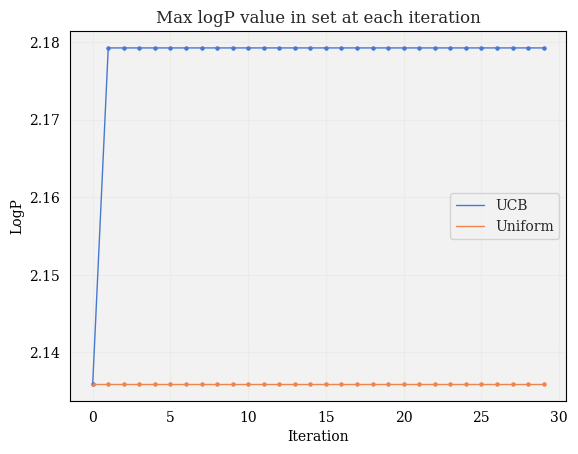

In [163]:
plt.plot(np.arange(len(best)), best, lw=1, label='UCB')
plt.scatter(np.arange(len(best)), best, s=5)

plt.plot(np.arange(len(best)), best_uniform, lw=1, label='Uniform')
plt.scatter(np.arange(len(best)), best_uniform, s=5)

plt.xlabel('Iteration')
plt.ylabel('LogP')
plt.title('Max logP value in set at each iteration')
plt.legend();